# Import main libraries 

In [1]:
# The causalTree package is not in CRAN, the most common R repository.
# To install it, uncomment the next lines as appropriate.
# install.packages("devtools")  # if you don't have this installed yet.
# devtools::install_github('susanathey/causalTree') 

library(causalTree)
# use e.g., install.packages("grf") to install any of the following packages.
library(grf)
library(rpart)
library(glmnet)
library(splines)
library(MASS)
library(lmtest)
library(sandwich)
library(ggplot2)
library(haven)
library(fastDummies)
library(tidyverse)
library(sf)

Loading required package: rpart

Loading required package: rpart.plot

Loading required package: data.table

Loading required package: Matrix

Loaded glmnet 4.1-4

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v tibble  3.1.6     v dplyr   1.0.8
v tidyr   1.2.0     v stringr 1.4.0
v readr   2.1.2     v forcats 0.5.1
v purrr   0.3.4     

-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::between()   masks data.table::between()
x tidyr::expand()    masks Matrix::expand()
x dplyr::filter()    masks stats::filter()
x dplyr::first()     masks data.table::first()
x dplyr::lag()       masks stats::lag()
x dplyr::last()      masks data.table::last()
x tidyr::pack()      masks Matrix::pack()
x dplyr

# Romano Wolf Correction 

In [2]:
# Auxiliary function to computes adjusted p-values 
# following the Romano-Wolf method.
# For a reference, see http://ftp.iza.org/dp12845.pdf page 8
#  t.orig: vector of t-statistics from original model
#  t.boot: matrix of t-statistics from bootstrapped models
romano_wolf_correction <- function(t.orig, t.boot) {
  abs.t.orig <- abs(t.orig)
  abs.t.boot <- abs(t.boot)
  abs.t.sorted <- sort(abs.t.orig, decreasing = TRUE)

  max.order <- order(abs.t.orig, decreasing = TRUE)
  rev.order <- order(max.order)

  M <- nrow(t.boot)
  S <- ncol(t.boot)

  p.adj <- rep(0, S)
  p.adj[1] <- mean(apply(abs.t.boot, 1, max) > abs.t.sorted[1])
  for (s in seq(2, S)) {
    cur.index <- max.order[s:S]
    p.init <- mean(apply(abs.t.boot[, cur.index, drop=FALSE], 1, max) > abs.t.sorted[s])
    p.adj[s] <- max(p.init, p.adj[s-1])
  }
  p.adj[rev.order]
}

# Computes adjusted p-values for linear regression (lm) models.
#    model: object of lm class (i.e., a linear reg model)
#    indices: vector of integers for the coefficients that will be tested
#    cov.type: type of standard error (to be passed to sandwich::vcovHC)
#    num.boot: number of null bootstrap samples. Increase to stabilize across runs.
# Note: results are probabilitistic and may change slightly at every run. 
#
# Adapted from the p_adjust from from the hdm package, written by Philipp Bach.
# https://github.com/PhilippBach/hdm_prev/blob/master/R/p_adjust.R
summary_rw_lm <- function(model, indices=NULL, cov.type="HC2", num.boot=10000) {

  if (is.null(indices)) {
    indices <- 1:nrow(coef(summary(model)))
  }
  # Grab the original t values.
  summary <- coef(summary(model))[indices,,drop=FALSE]
  t.orig <- summary[, "t value"]

  # Null resampling.
  # This is a trick to speed up bootstrapping linear models.
  # Here, we don't really need to re-fit linear regressions, which would be a bit slow.
  # We know that betahat ~ N(beta, Sigma), and we have an estimate Sigmahat.
  # So we can approximate "null t-values" by
  #  - Draw beta.boot ~ N(0, Sigma-hat) --- note the 0 here, this is what makes it a *null* t-value.
  #  - Compute t.boot = beta.boot / sqrt(diag(Sigma.hat))
  Sigma.hat <- vcovHC(model, type=cov.type)[indices, indices]
  se.orig <- sqrt(diag(Sigma.hat))
  num.coef <- length(se.orig)
  beta.boot <- mvrnorm(n=num.boot, mu=rep(0, num.coef), Sigma=Sigma.hat)
  t.boot <- sweep(beta.boot, 2, se.orig, "/")
  p.adj <- romano_wolf_correction(t.orig, t.boot)

  result <- cbind(summary[,c(1,2,4),drop=F], p.adj)
  colnames(result) <- c('Estimate', 'Std. Error', 'Orig. p-value', 'Adj. p-value')
  result
}

# Data Description
* stay             = The dependent variable is an indicator variable equal to 1 if teacher stayed an                      extra year at the same school next year.

* treat12          = Treatment unit : teacher working at Isolated school (S/. 500 soles or 134 USD dollars bonus per                          month). Control unit   : teacher works at Rural school (S/. 100 soles or 26 USD dollars bonus per month )
            
* tenured          = Permanent teacher and have the first priority to move between schools.

* level            = Kindergarten, Elementary and High School

* sex              = Sex of teacher

* age              = Age of teacher

* clasification    = unidocente, multigrado, completo

* cpelec           = Proxy of electricity

* cpwater          = proxy of water

* nlat_ie          = Latitud of school

* nlong_ie         = Longitud of school

* y_dim            = Latitud rescaled 

* x_dim            = Longitud rescaled

* ano              = year 

* strict_qualified = Qualification is defined by the possession of an educational college
degree.

* time_ie         = Time to main School District Office

* population_ccpp  = Surronding town’s population


# Clean Data

In [5]:
# Import data of 4 years about teacher retantion in Peru
data <- read_dta("C:/Users/sandr/Dropbox/MGTECON634_Project/data/matching_panel5_treat12.dta")

In [6]:
data

ano,dni_nexus,archivo,cod_mod,codplaza,codcargo,codtipotrab,codsubtipt,tenured,sex,...,teacher_position2014,nlat_ie2014,nlong_ie2014,cod_mod2017,public2017,teacher_position2017,nlat_ie2017,nlong_ie2017,especialidad,lLdd
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl+lbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>
2015,29543412,201512,2212,522401218112,13048,10,13,1,2,...,1,-5.88916,-79.53830,2212,1,1,-5.88916,-79.53830,matematica,NA
2014,16614859,201412,2212,522421218113,13048,10,13,1,2,...,1,-5.88916,-79.53830,2212,1,1,-5.88916,-79.53830,edfisica,NA
2015,16732242,201512,2212,522421218117,13048,10,13,1,2,...,1,-5.88916,-79.53830,2212,1,1,-5.88916,-79.53830,ccss,NA
2014,41089828,201412,2212,522421218117,13048,10,13,0,1,...,NA,NA,NA,452946,1,1,-6.50747,-79.85835,ciudadania,NA
2014,16732242,201412,2212,522421218117,13048,10,13,1,2,...,1,-5.88916,-79.53830,2212,1,1,-5.88916,-79.53830,ccss,NA
2015,16490890,201512,2212,522401218118,13048,10,13,1,1,...,1,-5.88916,-79.53830,2212,1,1,-5.88916,-79.53830,comunicacion,NA
2014,45407421,201412,2212,521401416515,13048,10,13,0,1,...,NA,NA,NA,1095702,1,1,-5.79553,-79.69655,matematica,NA
2013,31034981,201312,2212,522421218116,13048,10,13,1,2,...,1,-5.88916,-79.53830,1095702,1,1,-5.79553,-79.69655,ciencia,NA
2013,40422963,201312,2212,522431213111,13048,10,13,0,2,...,1,-5.88916,-79.53830,1553718,1,1,-5.76304,-79.46425,arte,NA


In [7]:
data_main_col <- data.frame(data$stay, data$treat12,data$tenured, 
                            data$level, data$sex, data$age, data$clasification, 
                            data$cpelec, data$cpwater, data$nlat_ie, data$nlong_ie,
                           data$x_dim, data$y_dim, data$ano, data$strict_qualified, 
                            data$time_ie, data$population_ccpp)
 
names(data_main_col) <- c('stay', 'treat12', 'tenured', 'level', 'sex', 'age', 
                       'clasification', 'cpelec', 'cpwater', "nlat_ie", "nlong_ie", 
                          "x_dim", "y_dim", "ano", "strict_qualified", "time_ie", "population_ccpp")
data_clean <- na.omit(data_main_col)

# Keep only temporary teachers and year 2016 
data_clean <- subset(data_clean, ano== 2016 & tenured == 0 & strict_qualified == 1)

In [8]:
# Dummy for sex, and categorical values for level and clasification 
data_clean$sex[data_clean$sex == 1] <- 1
data_clean$sex[data_clean$sex == 2] <- 0
data_clean$level <- as.factor(data_clean$level)
data_clean$clasification <- as.factor(data_clean$clasification)

In [9]:
# Create dummies from clasification and level vars
data_clean <- dummy_cols(data_clean, select_columns = c("clasification", "level"))

In [10]:
data_clean

stay,treat12,tenured,level,sex,age,clasification,cpelec,cpwater,nlat_ie,...,ano,strict_qualified,time_ie,population_ccpp,clasification_1,clasification_2,clasification_3,level_1,level_2,level_3
<dbl>,<dbl>,<dbl>,<fct>,<dbl+lbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>
0,0,0,2,0,50,2,1,1,-13.92740,...,2016,1,370.13519,515,0,1,0,0,1,0
0,1,0,2,1,34,2,1,1,-13.90584,...,2016,1,364.23318,184,0,1,0,0,1,0
0,1,0,2,1,33,2,1,1,-13.78590,...,2016,1,443.03857,139,0,1,0,0,1,0
0,1,0,2,1,41,2,1,1,-13.78590,...,2016,1,443.03857,139,0,1,0,0,1,0
0,1,0,2,1,31,2,1,1,-13.78590,...,2016,1,443.03857,139,0,1,0,0,1,0
0,0,0,2,0,39,3,1,1,-14.05990,...,2016,1,146.93188,447,0,0,1,0,1,0
1,0,0,2,1,31,3,1,1,-14.07739,...,2016,1,272.70847,708,0,0,1,0,1,0
0,0,0,2,0,41,3,1,1,-14.07739,...,2016,1,272.70847,708,0,0,1,0,1,0
1,0,0,2,0,42,2,1,1,-14.14660,...,2016,1,359.39798,41,0,1,0,0,1,0


# Replicate main results from paper about temprorary teachers 

In [11]:
# Treatment Effect on Retention for Teachers at Isolated/Rural Boundary
# Qualified Temporary
fmla <- formula(stay ~  treat12 + sex + age + 
                        factor(level) + factor(clasification) 
                        + cpelec + cpwater)
ols <- lm(fmla, data=subset(data, tenured==0 & strict_qualified == 1 & ano== 2016 ))
ols.res <- coeftest(ols, vcov=vcovHC(ols, type='HC2'))
#ols.res
summary(ols)


Call:
lm(formula = fmla, data = subset(data, tenured == 0 & strict_qualified == 
    1 & ano == 2016))

Residuals:
    Min      1Q  Median      3Q     Max 
-0.4330 -0.2964 -0.2522  0.6522  0.8336 

Coefficients:
                        Estimate Std. Error t value Pr(>|t|)    
(Intercept)             0.125048   0.020723   6.034 1.62e-09 ***
treat12                 0.047713   0.006041   7.898 2.94e-15 ***
sex                    -0.007348   0.006219  -1.181   0.2374    
age                     0.003071   0.000405   7.584 3.47e-14 ***
factor(level)2          0.004622   0.008742   0.529   0.5970    
factor(level)3          0.009403   0.011835   0.794   0.4269    
factor(clasification)2 -0.008398   0.009140  -0.919   0.3582    
factor(clasification)3  0.062801   0.010961   5.729 1.02e-08 ***
cpelec                 -0.020036   0.010036  -1.996   0.0459 *  
cpwater                 0.009932   0.006043   1.644   0.1003    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Resi

# Via Causal Trees 

In [12]:
outcome <- "stay"
treatment <- "treat12"
# covariates = c("tenured", "level", "sex", "age", "clasification", 
#                "cpelec", "cpwater", "nlat_ie", "nlong_ie")

[1] 2
[1] "CT"


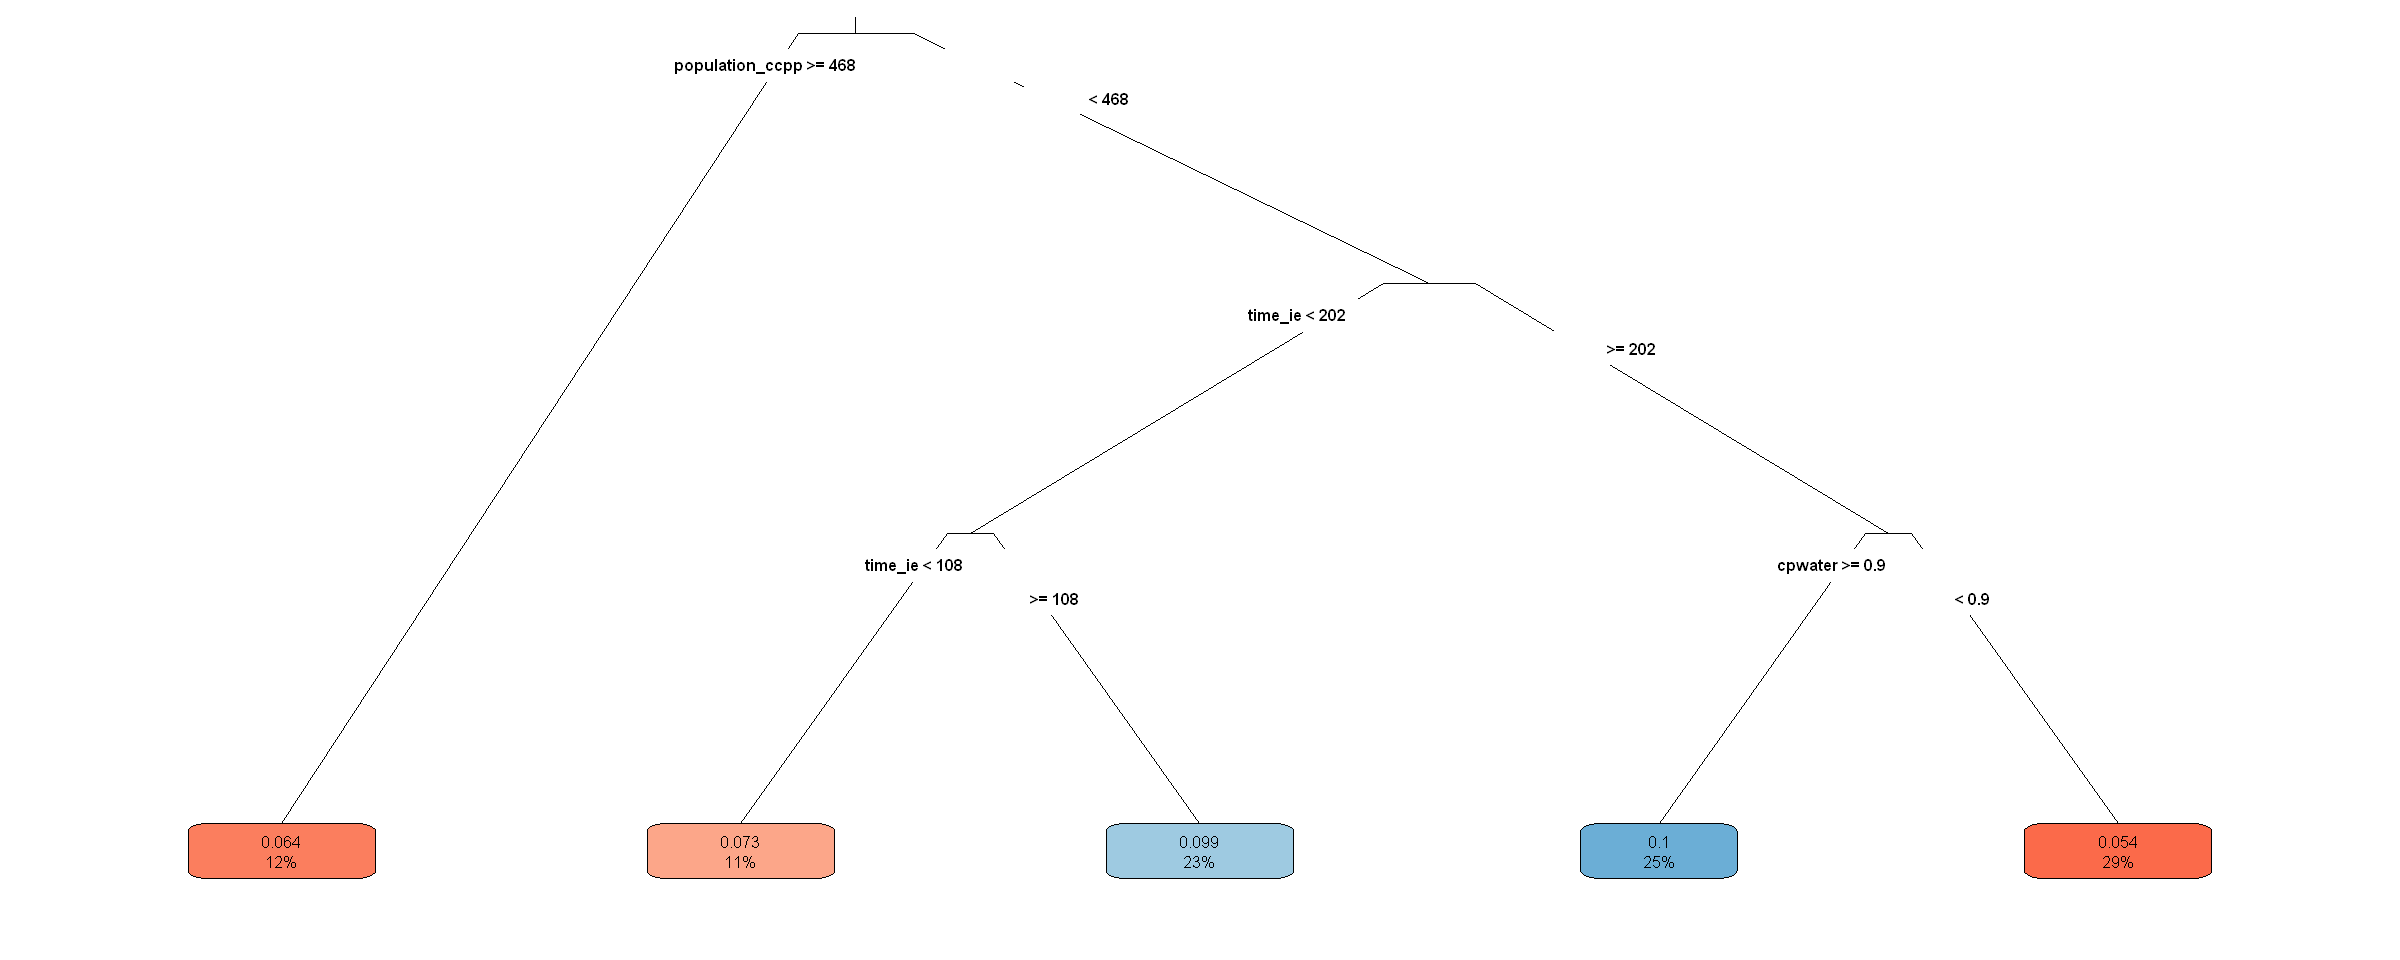

In [13]:
fmla <- formula(stay ~  tenured + sex + age + 
                        clasification_1 + clasification_2 + clasification_3 +
                        level_1 + level_2 + level_3 +
                        cpelec + cpwater + time_ie + population_ccpp)
# Dividing data into three subsets
indices <- split(seq(nrow(data_clean)), sort(seq(nrow(data_clean)) %% 3))
names(indices) <- c('split', 'est', 'test')

# Fitting the forest
ct.unpruned <- honest.causalTree(
  formula=fmla,            # Define the model
  data=data_clean[indices$split,],
  treatment=data_clean[indices$split, treatment],
  est_data=data_clean[indices$est,],
  est_treatment=data_clean[indices$est, treatment],
  minsize=100,                 # Min. number of treatment and control cases in each leaf
  HonestSampleSize=length(indices$est), #  Num obs used in estimation after splitting
  # We recommend not changing the parameters below
  split.Rule="CT",            # Define the splitting option
  cv.option="TOT",            # Cross validation options
  cp=0,                       # Complexity parameter
  split.Honest=TRUE,          # Use honesty when splitting
  cv.Honest=TRUE              # Use honesty when performing cross-validation
)

# Table of cross-validated values by tuning parameter.
ct.cptable <- as.data.frame(ct.unpruned$cptable)

# Obtain optimal complexity parameter to prune tree.
cp.selected <- which.min(ct.cptable$xerror)
cp.optimal <- ct.cptable[cp.selected, "CP"]

# Prune the tree at optimal complexity parameter.
ct.pruned <- prune(tree=ct.unpruned, cp=cp.optimal)

# Predict point estimates (on estimation sample)
tau.hat.est <- predict(ct.pruned, newdata=data_clean[indices$est,])

# Create a factor column 'leaf' indicating leaf assignment in the estimation set
num.leaves <- length(unique(tau.hat.est))
leaf <- factor(tau.hat.est, levels=sort(unique(tau.hat.est)), labels = seq(num.leaves))

# plots the learned tree
options(repr.plot.width=20, repr.plot.height=8)
rpart.plot(
  x=ct.pruned,        # Pruned tree
  type=3,             # Draw separate split labels for the left and right directions
  fallen=TRUE,        # Position the leaf nodes at the bottom of the graph
  leaf.round=1,       # Rounding of the corners of the leaf node boxes
  extra=100,          # Display the percentage of observations in the node
  branch=.1,          # Shape of the branch lines
  box.palette="RdBu", # Palette for coloring the node
  cex = 0.8,
  xcompact=FALSE,
  ycompact=FALSE)

In [14]:
# fmla <- formula(stay ~  tenured + sex + age + 
#                         clasification_1 + clasification_2 + clasification_3 +
#                         level_1 + level_2 + level_3 +
#                         cpelec + cpwater + nlat_ie + nlong_ie)
# # Dividing data into three subsets
# indices <- split(seq(nrow(data_clean)), sort(seq(nrow(data_clean)) %% 3))
# names(indices) <- c('split', 'est', 'test')

# # Fitting the forest
# ct.unpruned <- honest.causalTree(
#   formula=fmla,            # Define the model
#   data=data_clean[indices$split,],
#   treatment=data_clean[indices$split, treatment],
#   est_data=data_clean[indices$est,],
#   est_treatment=data_clean[indices$est, treatment],
#   minsize=150,                 # Min. number of treatment and control cases in each leaf
#   HonestSampleSize=length(indices$est), #  Num obs used in estimation after splitting
#   # We recommend not changing the parameters below
#   split.Rule="CT",            # Define the splitting option
#   cv.option="TOT",            # Cross validation options
#   cp=0,                       # Complexity parameter
#   split.Honest=TRUE,          # Use honesty when splitting
#   cv.Honest=TRUE              # Use honesty when performing cross-validation
# )

# # Table of cross-validated values by tuning parameter.
# ct.cptable <- as.data.frame(ct.unpruned$cptable)

# # Obtain optimal complexity parameter to prune tree.
# cp.selected <- which.min(ct.cptable$xerror)
# cp.optimal <- ct.cptable[cp.selected, "CP"]

# # Prune the tree at optimal complexity parameter.
# ct.pruned <- prune(tree=ct.unpruned, cp=cp.optimal)

# # Predict point estimates (on estimation sample)
# tau.hat.est <- predict(ct.pruned, newdata=data_clean[indices$est,])

# # Create a factor column 'leaf' indicating leaf assignment in the estimation set
# num.leaves <- length(unique(tau.hat.est))
# leaf <- factor(tau.hat.est, levels=sort(unique(tau.hat.est)), labels = seq(num.leaves))

# # plots the learned tree
# options(repr.plot.width=20, repr.plot.height=8)
# rpart.plot(
#   x=ct.pruned,        # Pruned tree
#   type=3,             # Draw separate split labels for the left and right directions
#   fallen=TRUE,        # Position the leaf nodes at the bottom of the graph
#   leaf.round=1,       # Rounding of the corners of the leaf node boxes
#   extra=100,          # Display the percentage of observations in the node
#   branch=.1,          # Shape of the branch lines
#   box.palette="RdBu", # Palette for coloring the node
#   cex = 0.8,
#   xcompact=FALSE,
#   ycompact=FALSE)

In [15]:
data <- data_clean  

# Average Covariate values wihtin each leaf

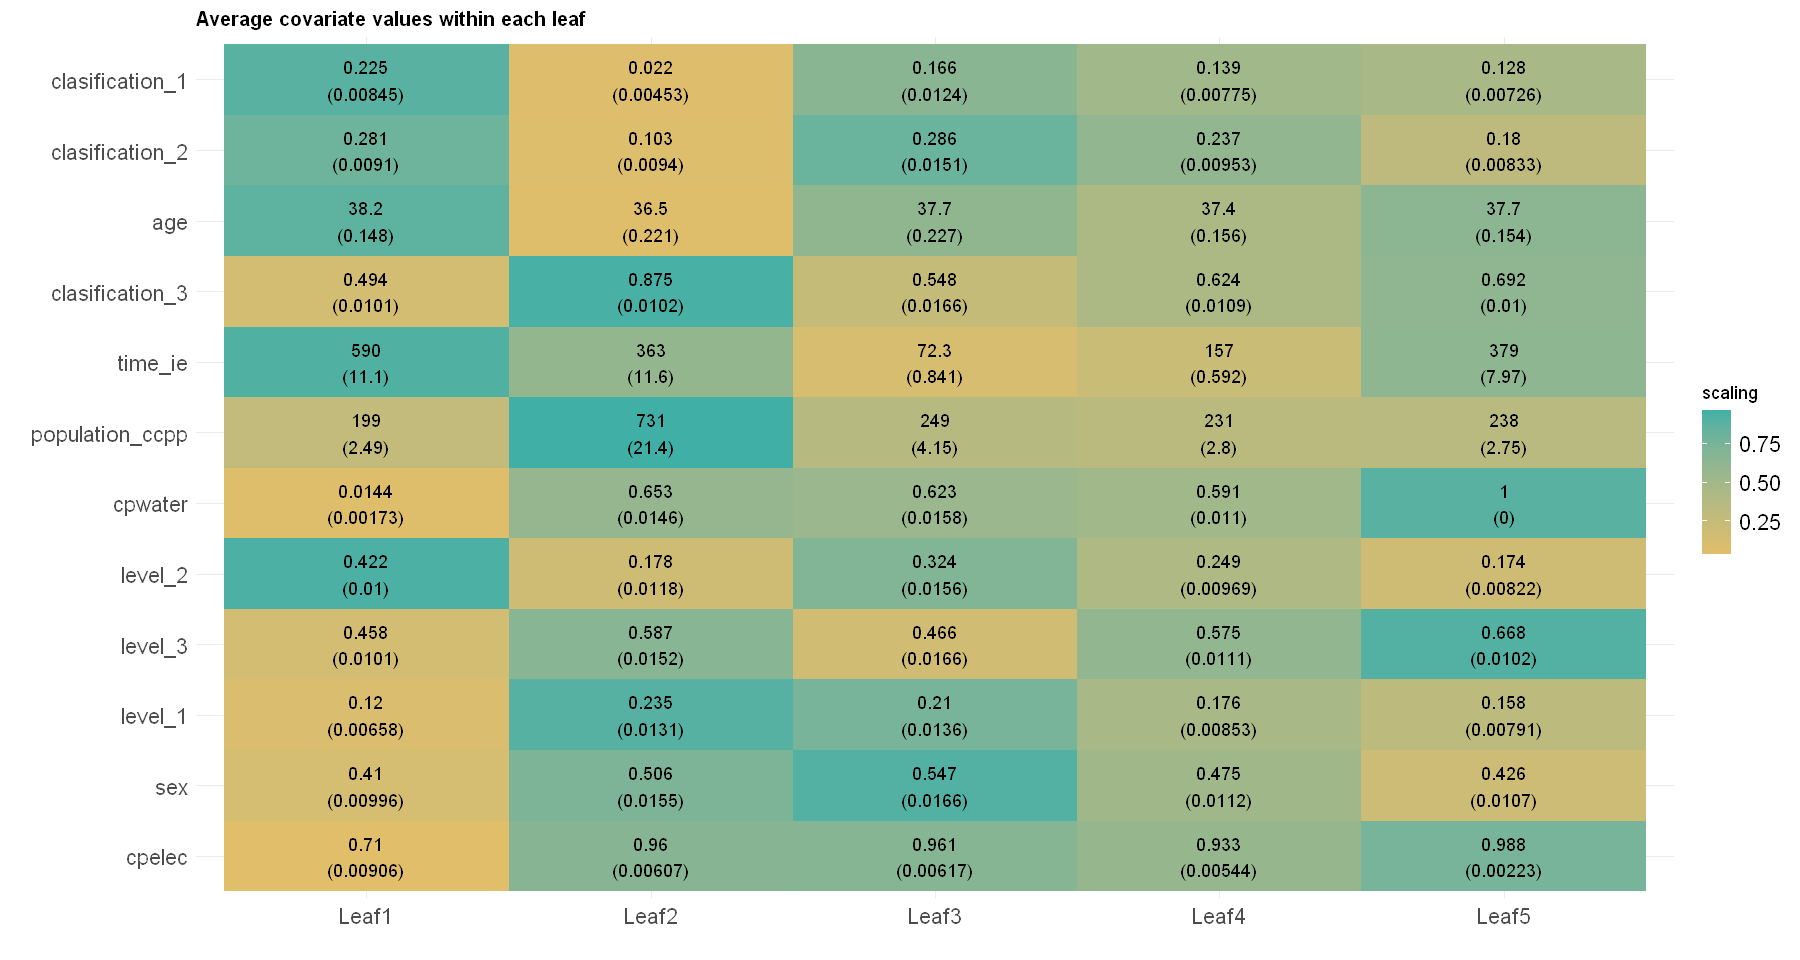

In [16]:
covariates = c("sex", "age", "cpelec", "cpwater", "time_ie", "population_ccpp", 
                "clasification_1", "clasification_2", "clasification_3", 
               "level_1", "level_2", "level_3"  )


df <- mapply(function(covariate) {
      # Looping over covariate names
      # Compute average covariate value per leaf (with correct standard errors)
      fmla <- formula(paste0(covariate, "~ 0 + leaf"))
      ols <- lm(fmla, data=transform(data[indices$est,], leaf=leaf))
      ols.res <- coeftest(ols, vcov=vcovHC(ols, "HC2"))
    
      # Retrieve results
      avg <- ols.res[,1]
      stderr <- ols.res[,2]
      
      # Tally up results
      data.frame(covariate, avg, stderr, leaf=paste0("Leaf", seq(num.leaves)), 
                 # Used for coloring
                 scaling=pnorm((avg - mean(avg))/sd(avg)), 
                 # We will order based on how much variation is 'explain' by the averages
                 # relative to the total variation of the covariate in the data
                 variation=sd(avg) / sd(data[,covariate]),
                 # String to print in each cell in heatmap below
                 labels=paste0(signif(avg, 3), "\n", "(", signif(stderr, 3), ")"))
}, covariates, SIMPLIFY = FALSE)

df <- do.call(rbind, df)

# a small optional trick to ensure heatmap will be in decreasing order of 'variation'
df$covariate <- reorder(df$covariate, order(df$variation))


# plot heatmap
options(repr.plot.width=15, repr.plot.height=8)
ggplot(df) + 
    aes(leaf, covariate, fig(50,50)) +
    geom_tile(aes(fill = scaling)) + 
    geom_text(aes(label = labels)) +
    scale_fill_gradient(low = "#E1BE6A", high = "#40B0A6") +
    ggtitle(paste0("Average covariate values within each leaf")) +
    theme_minimal() + 
    ylab("") + xlab("") +
    theme(plot.title = element_text(size = 12, face = "bold"),
          axis.text=element_text(size=13), 
          legend.text = element_text(size=13)) 

# Via GRF

In [17]:
covariates = c("sex", "age", 
               "clasification_1", "clasification_2", "clasification_3", 
               "level_1", "level_2", "level_3",
               "cpelec", "cpwater", "time_ie", "population_ccpp",  "nlat_ie" , "nlong_ie"                
                 )

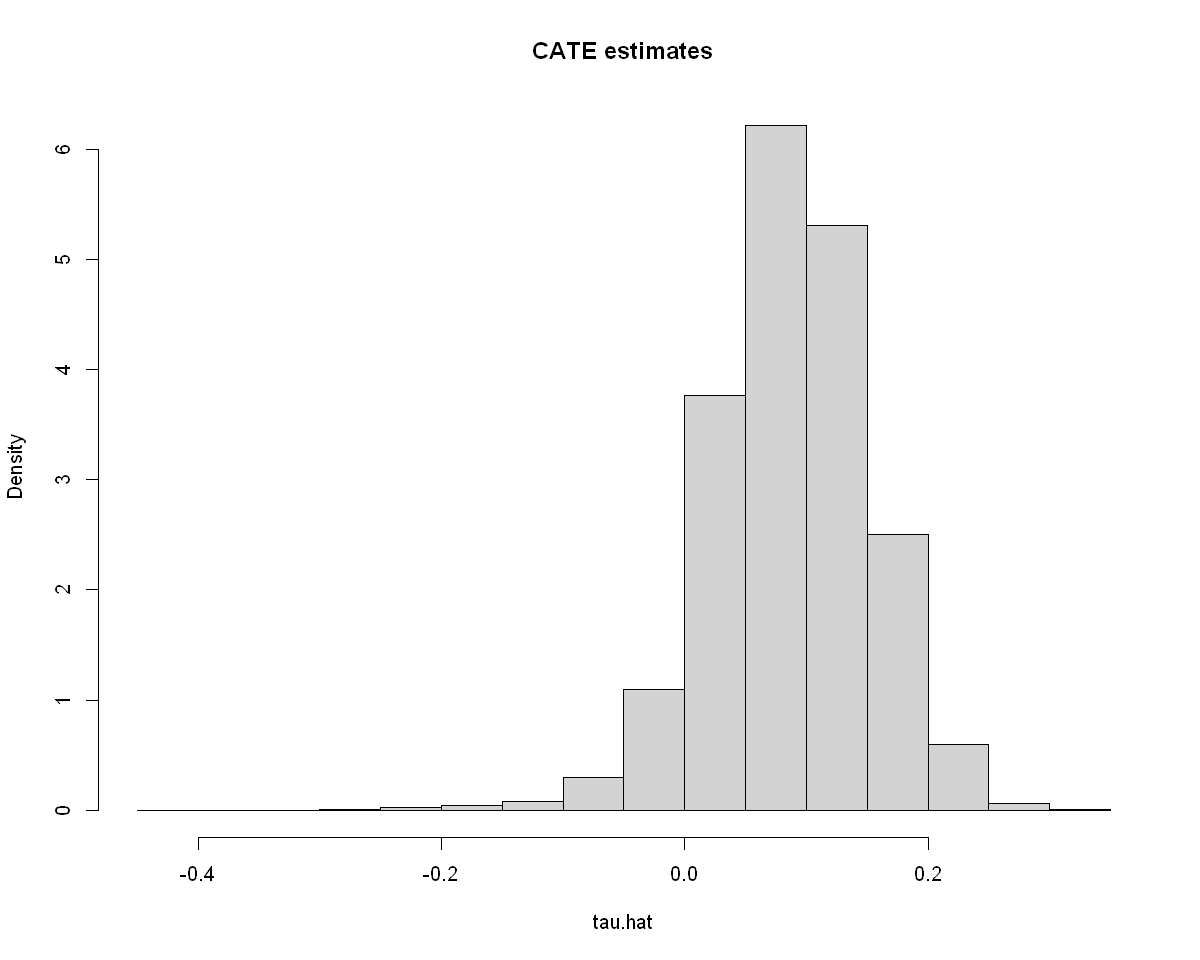

In [18]:
fmla <- formula(stay ~ sex + age + 
                        clasification_1 + clasification_2 + clasification_3 +
                        level_1 + level_2 + level_3 +
                        cpelec + cpwater + time_ie + population_ccpp + nlat_ie + nlong_ie)

# Preparing data to fit a causal forest
# fmla <- formula(paste0("~ 0 +", paste0(covariates, collapse="+")))
XX <- model.matrix(fmla, data)
W <- data[,treatment]
Y <- data[,outcome]

# Get predictions from forest fitted above.
forest.tau <- causal_forest(XX, Y, W, num.trees = 4000)

# Get predictions from forest fitted above.
tau.hat <- predict(forest.tau)$predictions  # tau(X) estimates

options(repr.plot.width=10, repr.plot.height=8)
# Do not use this for assessing heterogeneity. See text above.
hist(tau.hat, main="CATE estimates", freq=F)

In [19]:
# measure of variable importance that indicates how often a variable was used in a tree split. 
var_imp <- c(variable_importance(forest.tau))
names(var_imp) <- covariates
sorted_var_imp <- sort(var_imp, decreasing = TRUE)
sorted_var_imp[1:5]  # showing only first few

population_ccpp         nlat_ie            <NA>        nlong_ie clasification_1 
      0.3292395       0.1743622       0.1567591       0.1438530       0.1216658

In [20]:
var_imp

sex             age clasification_1 clasification_2 clasification_3 
    0.000000000     0.006244882     0.121665812     0.009294252     0.009968936 
        level_1         level_2         level_3          cpelec         cpwater 
    0.006446096     0.010240278     0.006654830     0.006901176     0.008253169 
        time_ie population_ccpp         nlat_ie        nlong_ie            <NA> 
    0.010116755     0.329239477     0.174362199     0.143852990     0.156759146

# Data-driven subgroups

In [21]:
var_imp <- c(variable_importance(forest.tau))
# Valid randomized data and observational data with unconfoundedness+overlap.
# Note: read the comments below carefully. 
# In randomized settings, do not estimate forest.e and e.hat; use known assignment probs.

covariates = c("sex", "age", "cpelec", "cpwater", "time_ie", "population_ccpp", 
                "clasification_1", "clasification_2", "clasification_3", 
               "level_1", "level_2", "level_3"  , "nlat_ie" , "nlong_ie")

# Prepare dataset
fmla <- formula(stay ~  tenured + sex + age + 
                        clasification_1 + clasification_2 + clasification_3 +
                        level_1 + level_2 + level_3 +
                        cpelec + cpwater + time_ie + population_ccpp + nlat_ie + nlong_ie)

X <- model.matrix(fmla, data)
W <- data[,treatment]
Y <- data[,outcome]
n <- nrow(data)

# Number of rankings that the predictions will be ranking on 
# (e.g., 2 for above/below median estimated CATE, 5 for estimated CATE quintiles, etc.)
num.rankings <- 5  

# Prepare for data.splitting
# Assign a fold number to each observation.
# The argument 'clusters' in the next step will mimick K-fold cross-fitting.
num.folds <- 20
folds <- sort(seq(n) %% num.folds) + 1

# Comment or uncomment depending on your setting.
# Observational setting with unconfoundedness+overlap (unknown assignment probs):
# forest <- causal_forest(X, Y, W, clusters = folds)
# Randomized settings with fixed and known probabilities (here: 0.5).
forest <- causal_forest(X, Y, W, , num.trees = 4000, clusters = folds)

# Retrieve out-of-bag predictions.
# Predictions for observation in fold k will be computed using 
# trees that were not trained using observations for that fold.
tau.hat <- predict(forest)$predictions


# Rank observations *within each fold* into quintiles according to their CATE predictions.
ranking <- rep(NA, n)
for (fold in seq(num.folds)) {
  tau.hat.quantiles <- quantile(tau.hat[folds == fold], probs = seq(0, 1, by=1/num.rankings))
  ranking[folds == fold] <- cut(tau.hat[folds == fold], tau.hat.quantiles, include.lowest=TRUE,labels=seq(num.rankings))
}

# For RCT

In [22]:
# Valid only in randomized settings.
# Average difference-in-means within each ranking

# Formula y ~ 0 + ranking + ranking:w
fmla <- paste0(outcome, " ~ 0 + ranking + ranking:", treatment)
ols.ate <- lm(fmla, data=transform(data, ranking=factor(ranking)))
ols.ate <- coeftest(ols.ate, vcov=vcovHC(ols.ate, type='HC2'))
interact <- which(grepl(":", rownames(ols.ate)))
ols.ate <- data.frame("ols", paste0("Q", seq(num.rankings)), ols.ate[interact, 1:2])
rownames(ols.ate) <- NULL # just for display
colnames(ols.ate) <- c("method", "ranking", "estimate", "std.err")
ols.ate

method,ranking,estimate,std.err
<chr>,<chr>,<dbl>,<dbl>
ols,Q1,0.003132332,0.01286089
ols,Q2,0.033280541,0.01241481
ols,Q3,0.060126433,0.01249305
ols,Q4,0.074881385,0.01293604
ols,Q5,0.051100198,0.01369208


# For observational settings

In [23]:
# Computing AIPW scores.
tau.hat <- predict(forest)$predictions
e.hat <- forest$W.hat # P[W=1|X]
m.hat <- forest$Y.hat # E[Y|X]

# Estimating mu.hat(X, 1) and mu.hat(X, 0) for obs in held-out sample
# Note: to understand this, read equations 6-8 in this vignette:
# https://grf-labs.github.io/grf/articles/muhats.html
mu.hat.0 <- m.hat - e.hat * tau.hat        # E[Y|X,W=0] = E[Y|X] - e(X)*tau(X)
mu.hat.1 <- m.hat + (1 - e.hat) * tau.hat  # E[Y|X,W=1] = E[Y|X] + (1 - e(X))*tau(X)

# AIPW scores
aipw.scores <- tau.hat + W / e.hat * (Y -  mu.hat.1) - (1 - W) / (1 - e.hat) * (Y -  mu.hat.0)
ols <- lm(aipw.scores ~ 0 + factor(ranking))
forest.ate <- data.frame("aipw", paste0("Q", seq(num.rankings)), coeftest(ols, vcov=vcovHC(ols, "HC2"))[,1:2])
colnames(forest.ate) <- c("method", "ranking", "estimate", "std.err")
rownames(forest.ate) <- NULL # just for display
forest.ate

method,ranking,estimate,std.err
<chr>,<chr>,<dbl>,<dbl>
aipw,Q1,0.04239013,0.01955523
aipw,Q2,0.06486935,0.01681789
aipw,Q3,0.08268185,0.02368329
aipw,Q4,0.09983223,0.01613513
aipw,Q5,0.10949224,0.04617573


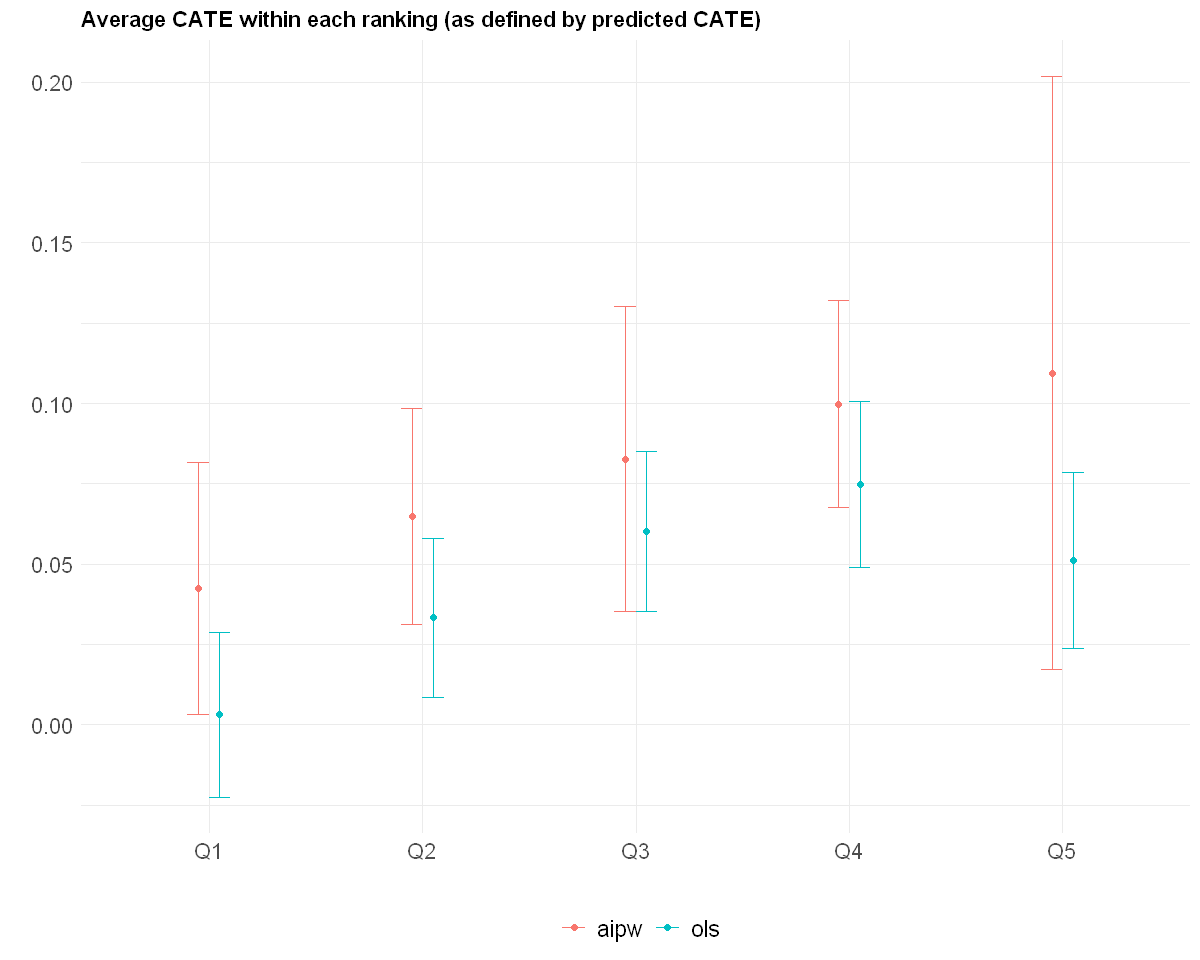

In [24]:
# Concatenate the two results.
res <- rbind(forest.ate, ols.ate)

# Plotting the point estimate of average treatment effect 
# and 95% confidence intervals around it.
options(repr.plot.width=10, repr.plot.height=8)
ggplot(res) +
  aes(x = ranking, y = estimate, group=method, color=method, fig(50,50)) + 
  geom_point(position=position_dodge(0.2)) +
  geom_errorbar(aes(ymin=estimate-2*std.err, ymax=estimate+2*std.err), width=.2, position=position_dodge(0.2)) +
  ylab("") + xlab("") +
  ggtitle("Average CATE within each ranking (as defined by predicted CATE)") +
  theme_minimal() +
  theme(plot.title = element_text(size = 13, face = "bold"),
        axis.text=element_text(size=13), 
        legend.position="bottom", legend.title = element_blank(), legend.text = element_text(size=14))

### Test predictions using difference-in-means estimator

In [25]:
# Valid in randomized settings only.

# y ~ ranking + w + ranking:w
fmla <- paste0(outcome, "~ ranking + ", treatment, " + ranking:", treatment) 
ols <- lm(fmla, data=transform(data, ranking=factor(ranking)))
interact <- which(sapply(names(coef(ols)), function(x) grepl(":", x)))
res <- summary_rw_lm(ols, indices=interact)
rownames(res) <- paste("Rank", 2:num.rankings, "- Rank 1") # just for display
res

,Estimate,Std. Error,Orig. p-value,Adj. p-value
Rank 2 - Rank 1,0.03014821,0.01792939,9.267869e-02,0.0878
Rank 3 - Rank 1,0.05699410,0.01808144,1.623010e-03,0.0046
Rank 4 - Rank 1,0.07174905,0.01834282,9.193925e-05,0.0004
Rank 5 - Rank 1,0.04796787,0.01878159,1.065558e-02,0.0205


In [26]:
# Valid in randomized and observational settings with unconfoundedness+overlap.

# Using AIPW scores computed above
ols <- lm(aipw.scores ~ 1 + factor(ranking))
res <- summary_rw_lm(ols, indices=2:num.rankings)
rownames(res) <- paste("Rank", 2:num.rankings, "- Rank 1") # just for display
res

,Estimate,Std. Error,Orig. p-value,Adj. p-value
Rank 2 - Rank 1,0.02247922,0.03800773,0.55423220,0.5475
Rank 3 - Rank 1,0.04029172,0.03800960,0.28913615,0.4602
Rank 4 - Rank 1,0.05744210,0.03801334,0.13077437,0.2905
Rank 5 - Rank 1,0.06710212,0.03801147,0.07752325,0.2370


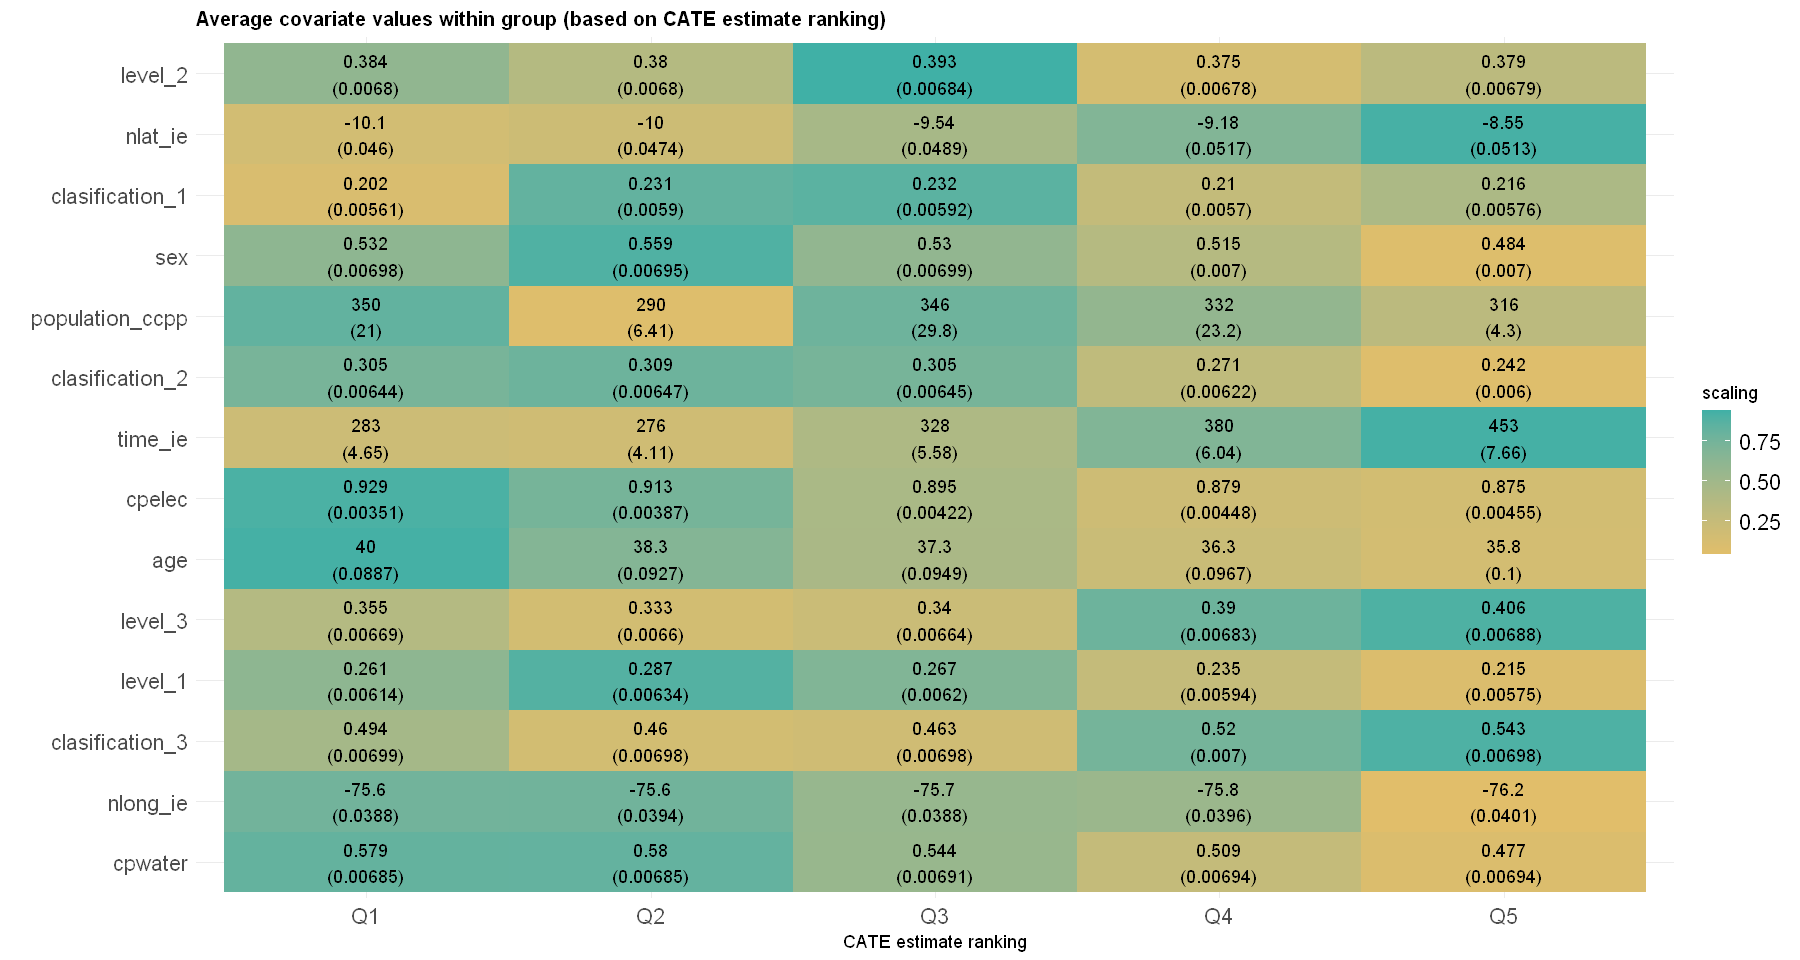

In [27]:
covariates = c("sex", "age", "cpelec", "cpwater", "time_ie", "population_ccpp", 
                "clasification_1", "clasification_2", "clasification_3", 
               "level_1", "level_2", "level_3"  , "nlat_ie" , "nlong_ie")

df <- mapply(function(covariate) {
      # Looping over covariate names
      # Compute average covariate value per ranking (with correct standard errors)
      fmla <- formula(paste0(covariate, "~ 0 + ranking"))
      ols <- lm(fmla, data=transform(data, ranking=factor(ranking)))
      ols.res <- coeftest(ols, vcov=vcovHC(ols, "HC2"))
    
      # Retrieve results
      avg <- ols.res[,1]
      stderr <- ols.res[,2]
      
      # Tally up results
      data.frame(covariate, avg, stderr, ranking=paste0("Q", seq(num.rankings)), 
                 # Used for coloring
                 scaling=pnorm((avg - mean(avg))/sd(avg)), 
                 # We will order based on how much variation is 'explain' by the averages
                 # relative to the total variation of the covariate in the data
                 variation=sd(avg) / sd(data[,covariate]),
                 # String to print in each cell in heatmap below
                 labels=paste0(signif(avg, 3), "\n", "(", signif(stderr, 3), ")"))
}, covariates, SIMPLIFY = FALSE)
df <- do.call(rbind, df)


# a small optional trick to ensure heatmap will be in decreasing order of 'variation'
df$covariate <- reorder(df$covariate, order(df$variation))

options(repr.plot.width=15, repr.plot.height=8)
# plot heatmap
ggplot(df) +
    aes(ranking, covariate) +
    geom_tile(aes(fill = scaling)) + 
    geom_text(aes(label = labels)) +
    scale_fill_gradient(low = "#E1BE6A", high = "#40B0A6") +
    ggtitle(paste0("Average covariate values within group (based on CATE estimate ranking)")) +
    theme_minimal() + 
    ylab("") + xlab("CATE estimate ranking") +
    theme(plot.title = element_text(size = 12, face = "bold"),
          axis.text=element_text(size=13), 
          legend.text = element_text(size=13)) 

### Best linear projection

In [28]:
# Best linear projection of the conditional average treatment effect on covariates
best_linear_projection(forest.tau, X)

Warning message in best_linear_projection(forest.tau, X):
"Estimated treatment propensities take values between 0.002 and 1 and in particular get very close to 0 or 1."



Best linear projection of the conditional average treatment effect.
Confidence intervals are cluster- and heteroskedasticity-robust (HC3):

                   Estimate  Std. Error t value Pr(>|t|)  
(Intercept)     -5.3065e-01  7.1613e-01 -0.7410  0.45870  
sex              1.9879e-02  2.9898e-02  0.6649  0.50612  
age             -1.1764e-03  8.6634e-04 -1.3579  0.17452  
clasification_1 -4.9888e-02  3.0734e-02 -1.6233  0.10455  
clasification_2 -6.4666e-02  4.6432e-02 -1.3927  0.16372  
level_1          1.5056e-02  2.0279e-02  0.7424  0.45784  
level_2         -1.5823e-02  1.5609e-02 -1.0137  0.31074  
cpelec          -6.8034e-02  3.0889e-02 -2.2025  0.02764 *
cpwater         -5.3731e-02  3.7911e-02 -1.4173  0.15641  
time_ie          2.5607e-05  1.4898e-05  1.7189  0.08565 .
population_ccpp -3.4261e-06  5.4056e-06 -0.6338  0.52622  
nlat_ie         -6.2599e-03  7.6098e-03 -0.8226  0.41074  
nlong_ie        -9.2864e-03  8.8017e-03 -1.0551  0.29141  
---
Signif. codes:  0 '***' 0.001

### Assessing heterogeneity

In [29]:
test_calibration(forest.tau)


Best linear fit using forest predictions (on held-out data)
as well as the mean forest prediction as regressors, along
with one-sided heteroskedasticity-robust (HC3) SEs:

                               Estimate Std. Error t value    Pr(>t)    
mean.forest.prediction          1.00859    0.13764  7.3278 1.205e-13 ***
differential.forest.prediction  0.75799    0.19073  3.9740 3.543e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


### Partial dependence

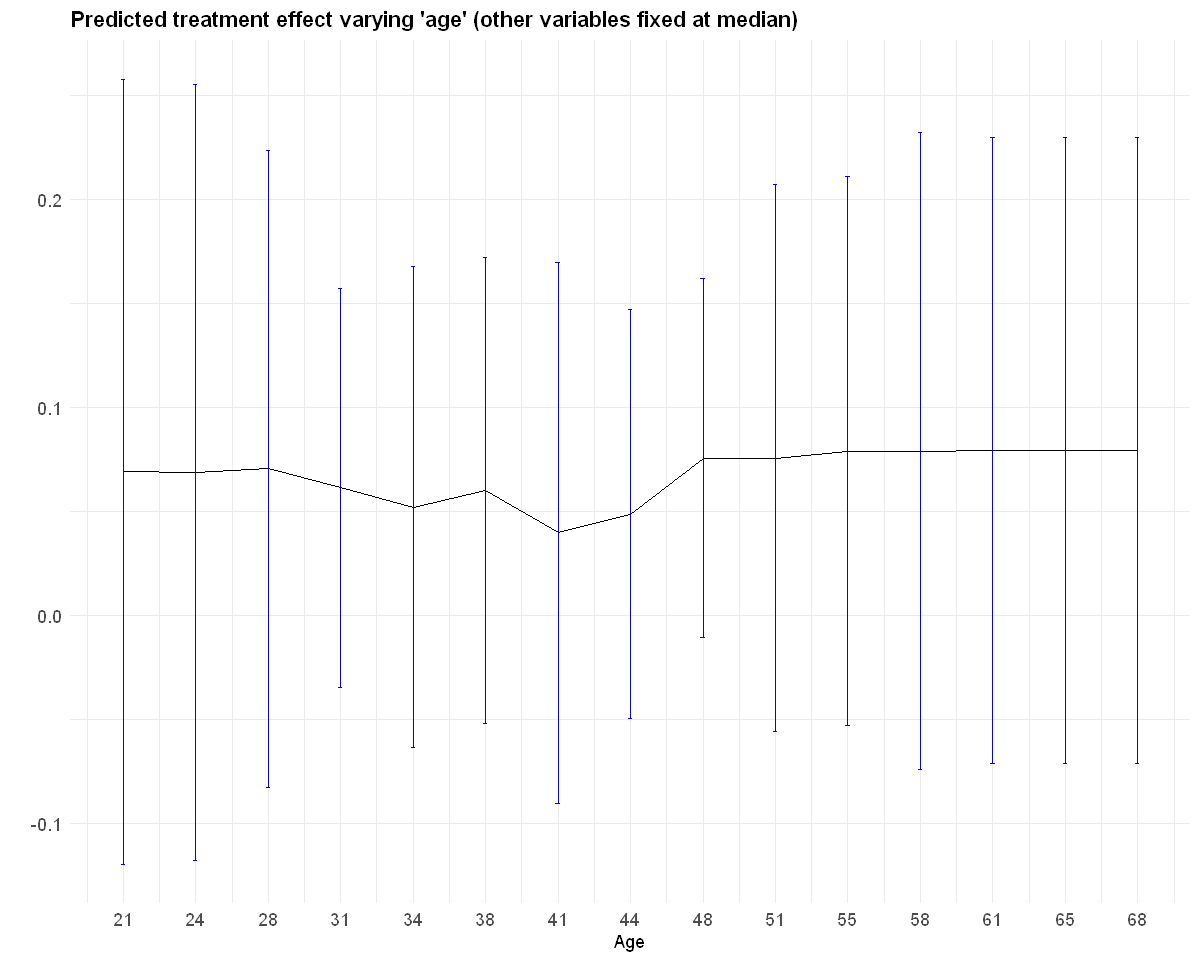

In [30]:
covariates = c("sex", "age", "cpelec", "cpwater", "time_ie", "population_ccpp", 
                "clasification_1", "clasification_2", "clasification_3", 
               "level_1", "level_2", "level_3"  , "nlat_ie" , "nlong_ie")

selected.covariate <- "age"
# other.covariates <- covariates
other.covariates <- covariates[which(covariates != selected.covariate)]

# Fitting a forest 
# (commented for convenience; no need re-fit if already fitted above)
fmla <- formula(paste0("~ 0 + ", paste0(covariates, collapse="+")))
# fmla <- formula(stay ~  tenured + sex + age + 
#                         factor(level) + factor(clasification)
#                         + cpelec + cpwater + x_dim + y_dim)
# Note: For smaller confidence intervals, set num.trees ~ sample size
X <- model.matrix(fmla, data)
W <- data[,treatment]
Y <- data[,outcome]
forest.tau <- causal_forest(X, Y, W, num.trees = 4000)  # few trees for speed here

# Compute a grid of values appropriate for the selected covariate
grid.size <- 15 
covariate.grid <- seq(min(data[,selected.covariate]), max(data[,selected.covariate]), length.out=grid.size)

# Other options for constructing a grid:
# For a binary variable, simply use 0 and 1
# grid.size <- 3
# covariate.grid <- c(0,2)  

# For a continuous variable, select appropriate percentiles
# percentiles <- c(1,2,3)
# grid.size <- length(percentiles)
# covariate.grid <- quantile(data[,selected.covariate], probs=percentiles)

# Take median of other covariates 
medians <- apply(data[, other.covariates, F], 2, median)

# Construct a dataset
data.grid <- data.frame(sapply(medians, function(x) rep(x, grid.size)), covariate.grid)
colnames(data.grid) <- c(other.covariates, selected.covariate)


# Expand the data
X.grid <- model.matrix(fmla, data.grid)

# Point predictions of the CATE and standard errors 
forest.pred <- predict(forest.tau, newdata = X.grid, estimate.variance=TRUE)

tau.hat <- forest.pred$predictions
tau.hat.se <- sqrt(forest.pred$variance.estimates)
                               
# Plot predictions for each group and 95% confidence intervals around them.
options(repr.plot.width=10, repr.plot.height=8)
data.pred <- transform(data.grid, tau.hat=tau.hat, ci.low = tau.hat - 2*tau.hat.se, ci.high = tau.hat + 2*tau.hat.se)
ggplot(data.pred) +
  geom_line(aes_string(x=selected.covariate, y="tau.hat", group = 1), color="black") +
  geom_errorbar(aes_string(x=selected.covariate, ymin="ci.low", ymax="ci.high", width=.2), color="blue") +
   ylab("") +
  ggtitle(paste0("Predicted treatment effect varying '", selected.covariate, "' (other variables fixed at median)")) +
  scale_x_continuous("Age", breaks=covariate.grid, labels=signif(covariate.grid, 2)) +
  theme_minimal() +
  theme(plot.title = element_text(size = 13, face = "bold"),
       axis.text=element_text(size=11)) 

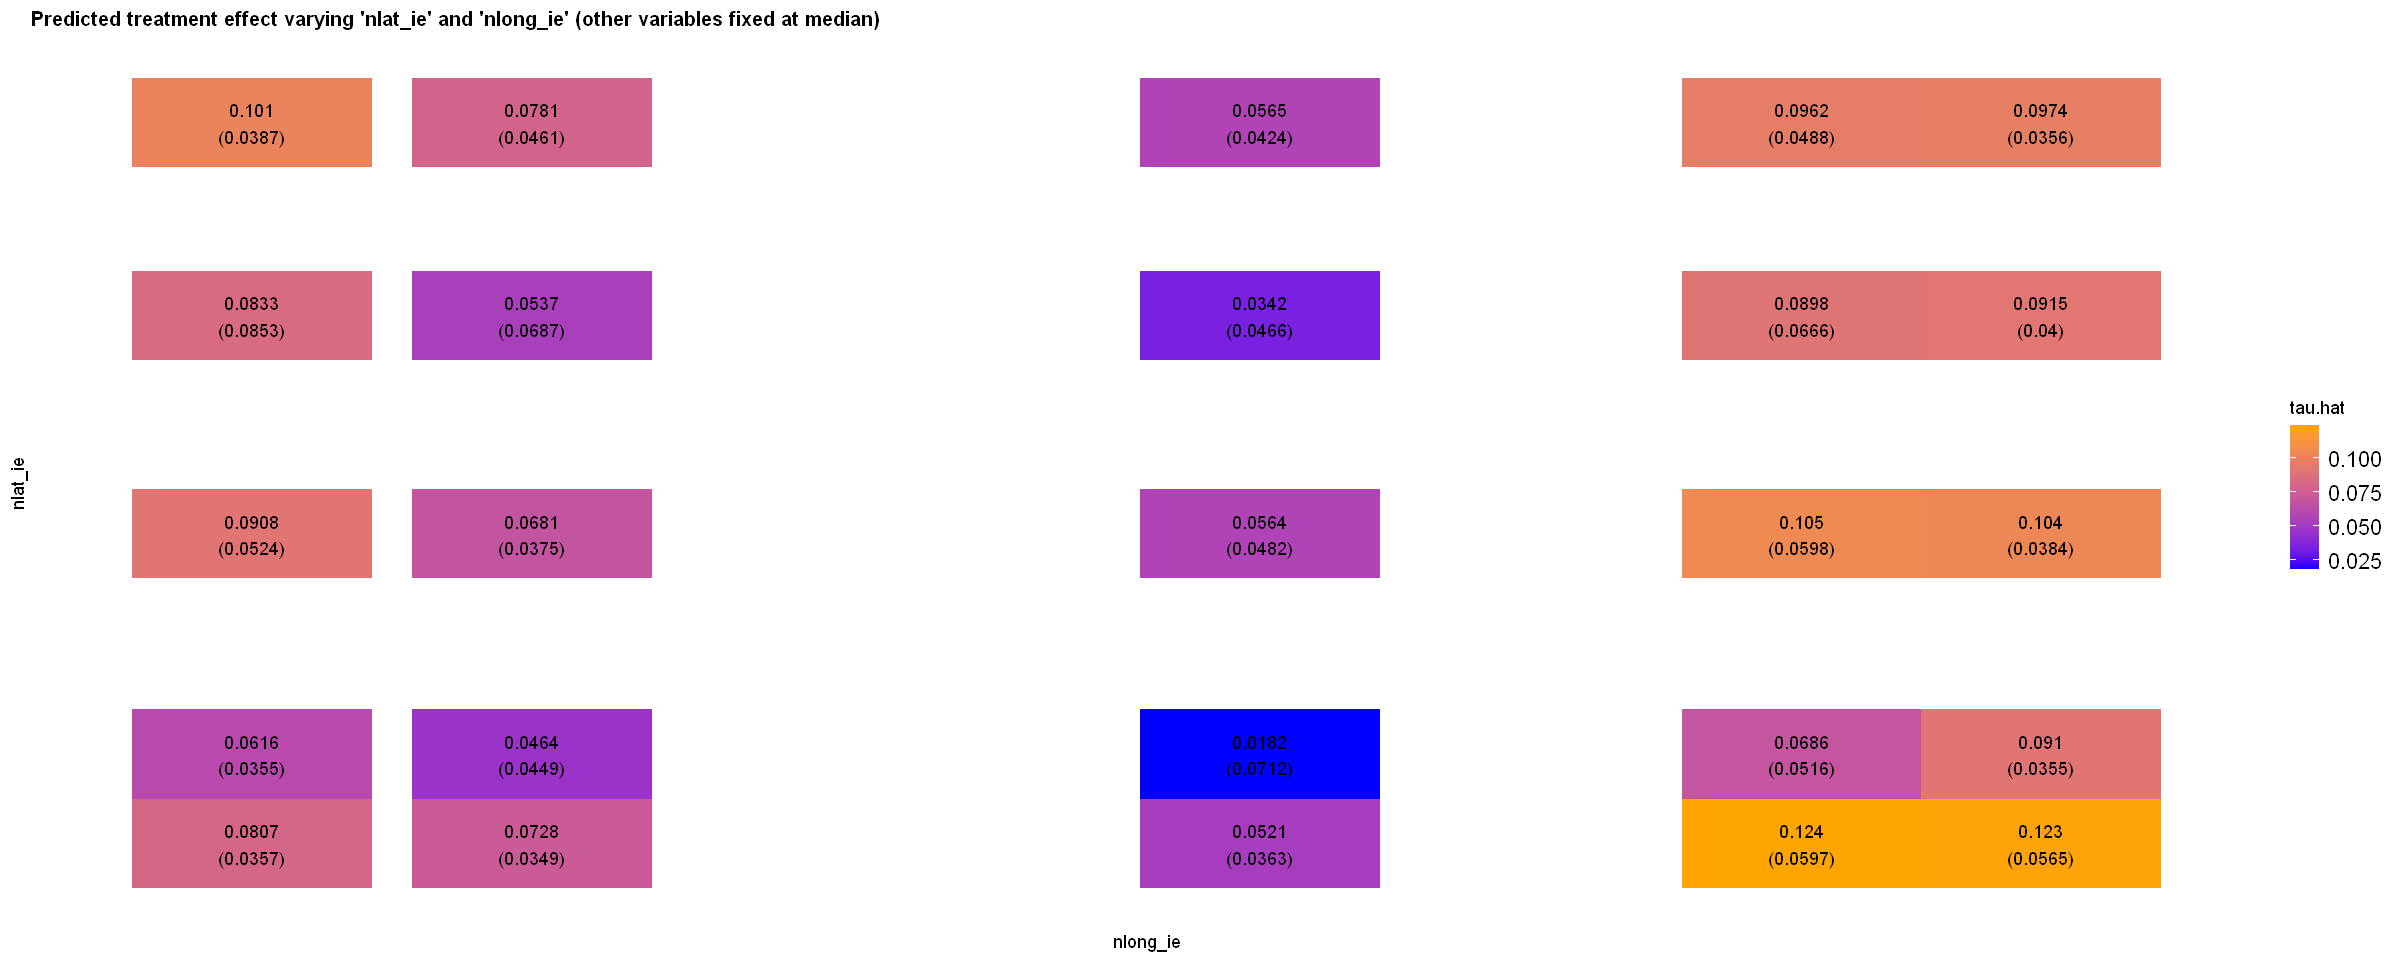

In [31]:
covariates = c("sex", "age", "cpelec", "cpwater", "time_ie", "population_ccpp", 
                "clasification_1", "clasification_2", "clasification_3", 
               "level_1", "level_2", "level_3"  , "nlat_ie" , "nlong_ie")

fmla <- formula(paste0("~ 0 + ", paste0(covariates, collapse="+")))

x1 <- 'nlat_ie'
x2 <- 'nlong_ie'
selected.covariates <- c(x1, x2)
other.covariates <- covariates[-which(covariates %in% selected.covariates)]

# Compute a grid of values appropriate for the selected covariate
# See other options for constructing grids in the snippet above.

percentiles <- c(0.1, 0.25, 0.5, 0.75, 0.9)
grid.size <- length(percentiles)
x1.grid <- quantile(data[,x1], probs=percentiles)

# x2.grid.size <- length(percentiles)
x2.grid <- quantile(data[,x2], probs=percentiles)

# Take median of other covariates 
medians <- apply(data[, other.covariates, F], 2, median)

# Construct dataset
data.grid <- data.frame(
                sapply(medians, function(x) rep(x, grid.size)), 
                expand.grid(x1.grid, x2.grid))
colnames(data.grid) <- c(other.covariates, selected.covariates)

# Expand the data according to formula used to fit forest
X.grid <- model.matrix(fmla, data.grid)

# Forest-based point estimates of CATE and standard errors around them
forest.pred <- predict(forest.tau, newdata = X.grid, estimate.variance=TRUE)
tau.hat <- forest.pred$predictions
tau.hat.se <- sqrt(forest.pred$variance.estimates)

# A vector of labels for plotting below
labels <- mapply(function(est, se) paste0(signif(est, 3), "\n", "(", signif(se, 3), ")"), tau.hat, tau.hat.se)
df <- data.frame(X.grid, tau.hat, labels)

# Plotting
options(repr.plot.width=20, repr.plot.height=8)
ggplot(df) +
    aes(nlat_ie, nlong_ie) +
    geom_tile(aes(fill = tau.hat)) + 
    geom_text(aes(label = labels)) +
    scale_fill_gradient(low = "blue", high = "orange") +
    scale_y_continuous("nlat_ie", breaks=x1.grid, labels=signif(x1.grid, 2)) +
    scale_x_continuous("nlong_ie", breaks=x2.grid, labels=signif(x2.grid, 2)) +
    ggtitle(paste0("Predicted treatment effect varying '", x1, "' and '", x2, "' (other variables fixed at median)")) +
    theme_minimal() +
    theme(plot.title = element_text(size = 12, face = "bold"),
          axis.text=element_text(size=13), 
          legend.text = element_text(size=13))

In [32]:
peru_boundaries <- read.csv('../scripts/Peru_shapefile_adm0/peru_boundaries.csv')
attach(peru_boundaries)
attach(data)

In [54]:
table(data$treat12)


    0     1 
 9591 15922 

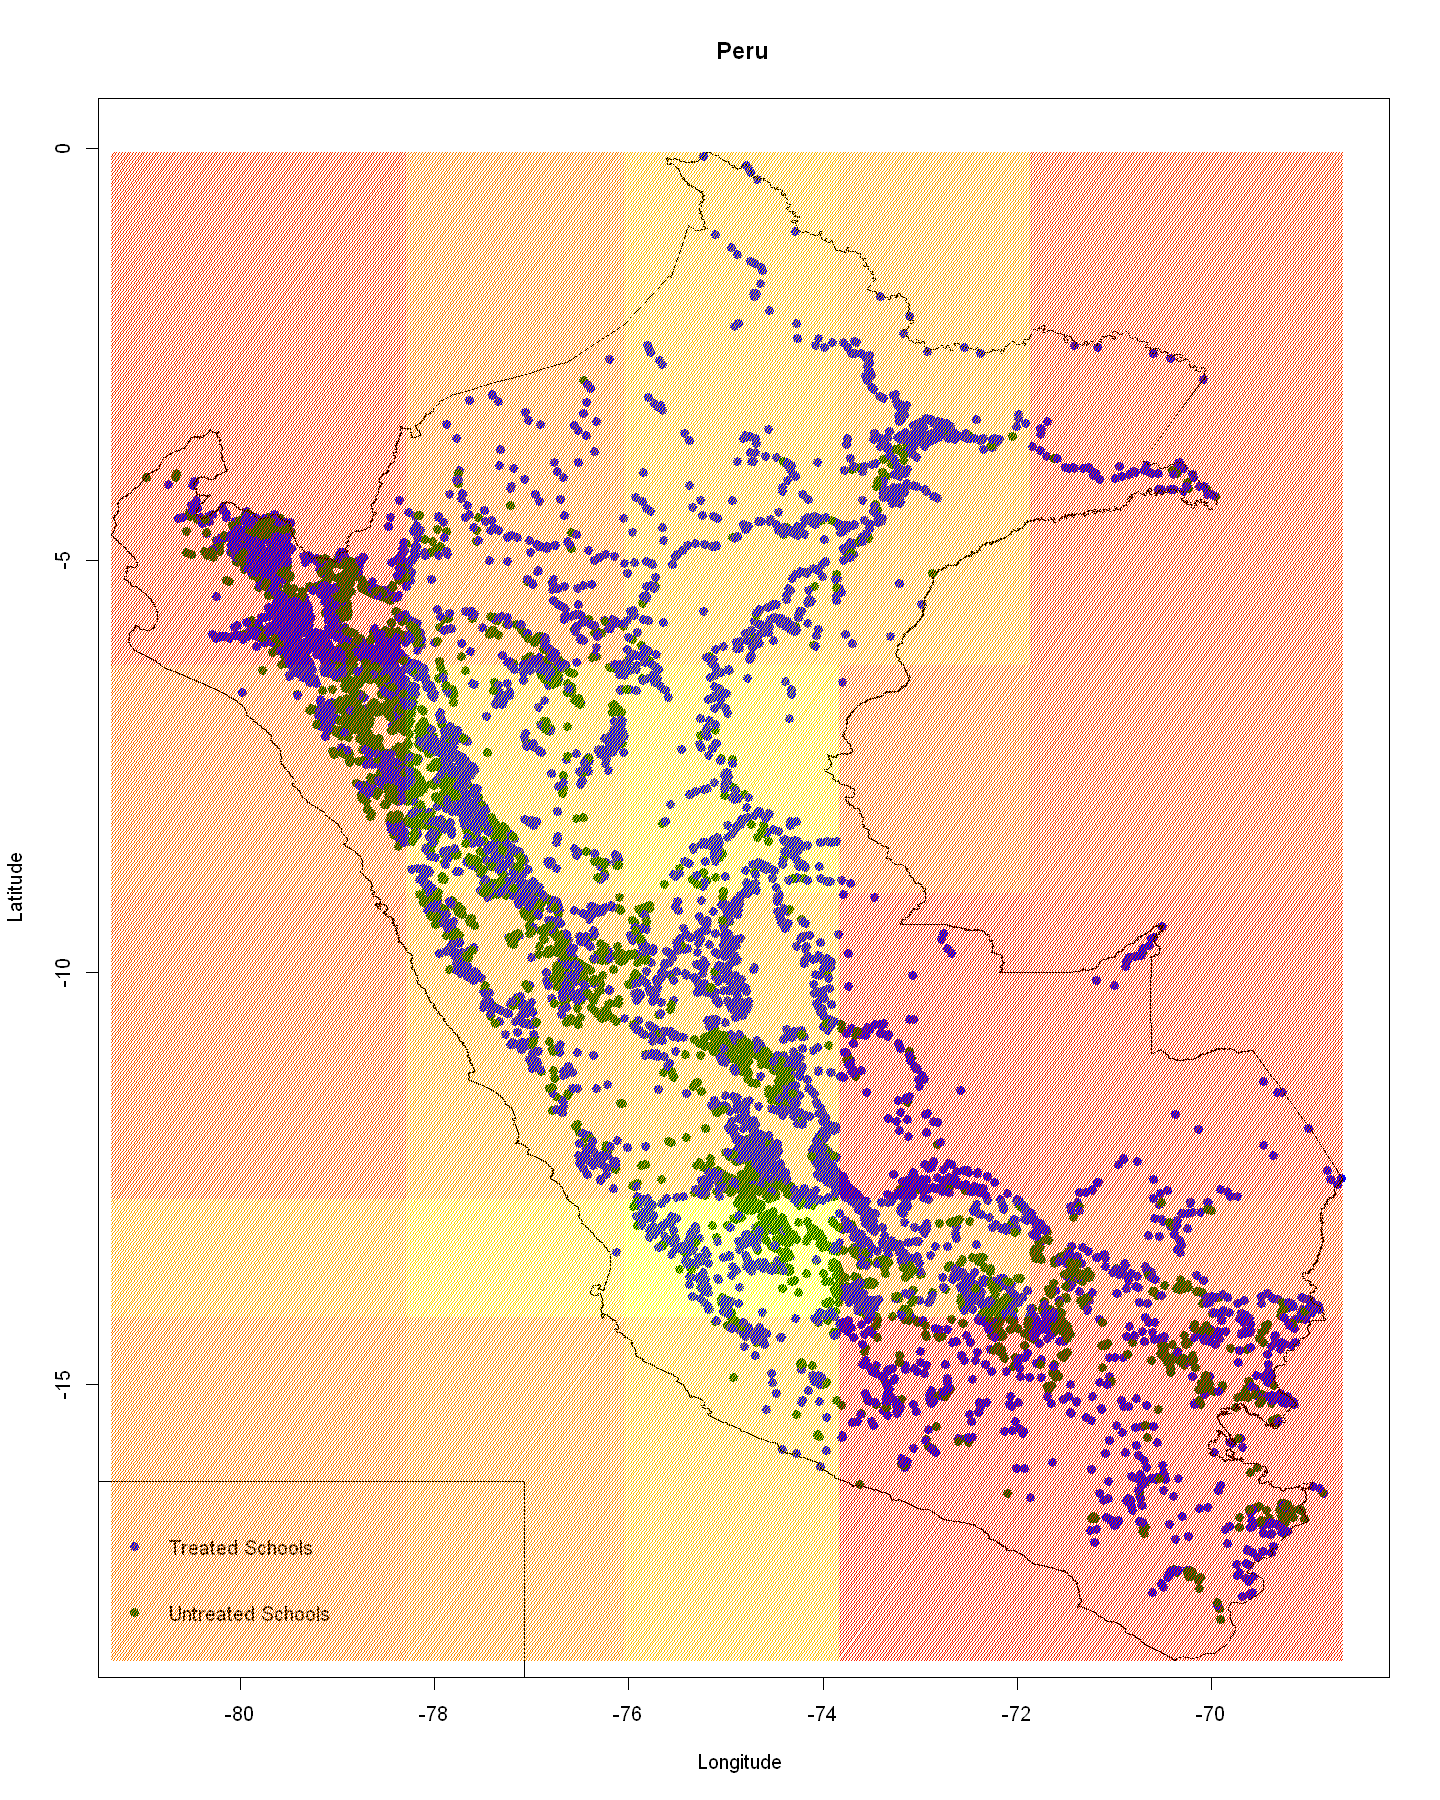

In [72]:
options(repr.plot.width=12, repr.plot.height=15)

col1 <- rgb(255, 255, 0, maxColorValue = 255)  
col2 <- rgb(255, 220, 0, maxColorValue = 255)
col3 <- rgb(255, 215, 0, maxColorValue = 255)
col4 <- rgb(255, 190, 0, maxColorValue = 255)
col5 <- rgb(255, 195, 0, maxColorValue = 255)
col6 <- rgb(255, 180, 0, maxColorValue = 255)
col7 <- rgb(255, 185, 0, maxColorValue = 255)
col8 <- rgb(255, 170, 0, maxColorValue = 255)
col9 <- rgb(255, 164, 0, maxColorValue = 255)
col10 <- rgb(255, 150, 0, maxColorValue = 255)
col11 <- rgb(255, 145, 0, maxColorValue = 255)  
col12 <- rgb(255, 130, 0, maxColorValue = 255)
col13 <- rgb(255, 125, 0, maxColorValue = 255)
col14 <- rgb(255, 110, 0, maxColorValue = 255)
col15 <- rgb(255, 105, 0, maxColorValue = 255)
col16 <- rgb(255, 90, 0, maxColorValue = 255)
col17 <- rgb(255, 80, 0, maxColorValue = 255)
col18 <- rgb(255, 70, 0, maxColorValue = 255)
col19 <- rgb(255, 65, 0, maxColorValue = 255)
col20 <- rgb(255, 60, 0, maxColorValue = 255)
col21 <- rgb(255, 55, 0, maxColorValue = 255)  
col22 <- rgb(255, 50, 0, maxColorValue = 255)
col23 <- rgb(255, 45, 0, maxColorValue = 255)
col24 <- rgb(255, 40, 0, maxColorValue = 255)
col25 <- rgb(255, 35, 0, maxColorValue = 255)

plot(nlong_ie, nlat_ie, main="Peru",
   xlab="Longitude ", ylab="Latitude", pch=ifelse(W, 16, 16), col=ifelse(W, "blue", "darkgreen"))
legend("bottomleft", legend=c("Treated Schools", "Untreated Schools"),
       col= c("blue", "darkgreen"), pch=16)
lines(longitude, latitude, main="Peru",
   xlab="Longitude ", ylab="Latitude", pch=1, , col = "black")


rect(-81.3282305, -18.3501167, -78.28714, -14.173208, density = 120, angle = 45, col = col13, border = NA)
rect(-81.3282305, -14.173208, -78.28714, -12.74141, density = 120, angle = 45, col = col8, border = NA)
rect(-81.3282305, -12.74141, -78.28714, -9.02429 , density = 120, angle = 45, col = col16, border = NA)
rect(-81.3282305, -9.02429, -78.28714, -6.25722, density = 120, angle = 45, col = col14, border = NA)
rect(-81.3282305, -6.25722, -78.28714, -0.0392818, density = 120, angle = 45, col = col21, border = NA)

rect(-78.28714, -18.3501167, -76.049, -14.173208, density = 120, angle = 45, col = col11, border = NA)
rect(-78.28714, -14.173208, -76.049, -12.74141, density = 120, angle = 45, col = col3, border = NA)
rect(-78.28714, -12.74141, -76.049, -9.02429 , density = 120, angle = 45, col = col9, border = NA)
rect(-78.28714, -9.02429, -76.049, -6.25722, density = 120, angle = 45, col = col5, border = NA)
rect(-78.28714, -6.25722, -76.049, -0.0392818, density = 120, angle = 45, col = col12, border = NA)

rect(-76.049, -18.3501167, -73.82824, -14.173208, density = 120, angle = 45, col = col4, border = NA)
rect(-76.049, -14.173208, -73.82824, -12.74141, density = 120, angle = 45, col = col1, border = NA)
rect(-76.049, -12.74141, -73.82824, -9.02429, density = 120, angle = 45, col = col6, border = NA)
rect(-76.049, -9.02429, -73.82824, -6.25722, density = 120, angle = 45, col = col2, border = NA)
rect(-76.049, -6.25722, -73.82824, -0.0392818, density = 120, angle = 45, col = col7, border = NA)

rect(-73.82824, -18.3501167, -71.8658, -14.173208, density = 120, angle = 45, col = col25, border = NA)
rect(-73.82824, -14.173208, -71.8658, -12.74141, density = 120, angle = 45, col = col10, border = NA)
rect(-73.82824, -12.74141, -71.8658, -9.02429, density = 120, angle = 45, col = col23, border = NA)
rect(-73.82824, -9.02429, -71.8658, -6.25722, density = 120, angle = 45, col = col15, border = NA)
rect(-73.82824, -6.25722, -71.8658, -0.0392818, density = 120, angle = 45, col = col9, border = NA)

rect(-71.8658, -18.3501167, -68.6519906, -14.173208, density = 120, angle = 45, col = col24, border = NA)
rect(-71.8658, -14.173208, -68.6519906, -12.74141, density = 120, angle = 45, col = col17, border = NA)
rect(-71.8658, -12.74141, -68.6519906, -9.02429 , density = 120, angle = 45, col = col22, border = NA)
rect(-71.8658, -9.02429, -68.6519906, -6.25722, density = 120, angle = 45, col = col18, border = NA)
rect(-71.8658, -6.25722, -68.6519906, -0.0392818, density = 120, angle = 45, col = col20, border = NA)

## Policy Learning

In [85]:
# Read in data
n <- nrow(data)

# NOTE: We'll invert treatment and control, compared to previous chapters
data$treat12 <- 1 - data$treat12

# Treatment is the wording of the question:
# 'does the the gov't spend too much on 'assistance to the poor' (control: 0)
# 'does the the gov't spend too much on "welfare"?' (treatment: 1)

# Outcome: 1 for 'yes', 0 for 'no'
outcome <- "stay"
treatment <- "treat12"
covariates = c("sex", "age", "cpelec", "cpwater", "time_ie", "population_ccpp", 
                "clasification_1", "clasification_2", "clasification_3", 
               "level_1", "level_2", "level_3"  , "nlat_ie" , "nlong_ie")

In [100]:
# Only valid in randomized setting
X <- data[,covariates]
Y <- data[,outcome]
W <- data[,treatment]

pi <- (X[,"clasification_3"] == 1) | (X[,"age"] < 35)
# pi <- (X[,"age"] < 35)
A <- pi == 1
value.estimate <- mean(Y[A & (W==1)]) * mean(A) + mean(Y[!A & (W==0)]) * mean(!A)
value.stderr <- sqrt(var(Y[A & (W==1)]) / sum(A & (W==1)) * mean(A)^2 + var(Y[!A & (W==0)]) / sum(!A & W==0) * mean(!A)^2)
print(paste("Value estimate:", value.estimate, "Std. Error:", value.stderr))

[1] "Value estimate: 0.268521374624217 Std. Error: 0.00409423960248219"


In [101]:
# Valid in randomized settings and observational settings with unconfoundedness + overlap
fmla <- formula(paste0("~", paste(covariates, collapse="+")))
X <- model.matrix(fmla, data)
Y <- data[,outcome]
W <- data[,treatment]
  
# Estimate a causal forest
# Important: comment/uncomment as appropriate.
# Randomized setting (known, fixed assignment probability):
forest <- causal_forest(X, Y, W)
# Observational setting with unknown probability:
# forest <- causal_forest(X, Y, W)

# Estimate a causal forest
tau.hat <- predict(forest)$predictions

# Estimate outcome model for treated and propensity scores
mu.hat.1 <- forest$Y.hat + (1 - forest$W.hat) * tau.hat  # E[Y|X,W=1] = E[Y|X] + (1-e(X))tau(X)
mu.hat.0 <- forest$Y.hat - forest$W.hat * tau.hat  # E[Y|X,W=0] = E[Y|X] - e(X)tau(X)

# Compute AIPW scores
gamma.hat.1 <- mu.hat.1 + W / forest$W.hat * (Y - mu.hat.1)
gamma.hat.0 <- mu.hat.0 + (1-W) / (1-forest$W.hat) * (Y - mu.hat.0)

In [115]:
# Valid in randomized settings and observational settings with unconfoundedness + overlap
gamma.hat.pi <- pi * gamma.hat.1 + (1 - pi) * gamma.hat.0
value.estimate <- mean(gamma.hat.pi, na.rm=TRUE)
value.stderr <- sd(gamma.hat.pi,na.rm=TRUE) / sqrt(length(gamma.hat.pi))
print(paste("Value estimate:", value.estimate, "Std. Error:", value.stderr))

[1] "Value estimate: 0.230145766691323 Std. Error: 0.00321700433319816"


In [116]:
# Valid in randomized settings and observational settings with unconfoundedness + overlap
pi.2 <- .5
gamma.hat.pi.1 <- pi * gamma.hat.1 + (1 - pi) * gamma.hat.0
gamma.hat.pi.2 <- pi.2 * gamma.hat.1 + (1 - pi.2) * gamma.hat.0
gamma.hat.pi.diff <- gamma.hat.pi.1 - gamma.hat.pi.2
diff.estimate <- mean(gamma.hat.pi.diff, na.rm=TRUE)
diff.stderr <- sd(gamma.hat.pi.diff, na.rm=TRUE) / sqrt(length(gamma.hat.pi.diff))
print(paste("Difference estimate:", diff.estimate, "Std. Error:", diff.stderr))

[1] "Difference estimate: -0.0259064743437222 Std. Error: 0.00311059900486522"
